
# <span style="color:rgb(213,80,0)">Pseudo\-Two\-Dimensional (P2D) Lithium\-Ion Battery Model</span>

This example demonstrates how to setup a P2D model of a Li\-ion battery and run a simple simulation.


In [1]:
% Clear the workspace and close open figures
clear
close all

## Import the required modules from MRST

load MRST modules


In [2]:
mrstModule add ad-core mrst-gui mpfa agmg linearsolvers

## Setup the properties of Li\-ion battery materials and cell design

The properties and parameters of the battery cell, including the architecture and materials, are set using an instance of :class:`BatteryInputParams [Battery.BatteryInputParams](http://battery.batteryinputparams)`. This class is used to initialize the simulation and it propagates all the parameters throughout the submodels. The input parameters can be set manually or provided in json format. All the parameters for the model are stored in the inputparams object.


In [3]:
jsonstruct = parseBattmoJson(fullfile('ParameterData','BatteryCellParameters','LithiumIonBatteryCell','lithium_ion_battery_nmc_graphite.json'));

% We define some shorthand names for simplicity.
ne      = 'NegativeElectrode';
pe      = 'PositiveElectrode';
elyte   = 'Electrolyte';
thermal = 'ThermalModel';
co      = 'Coating';
am      = 'ActiveMaterial';
itf     = 'Interface';
sd      = 'SolidDiffusion';
ctrl    = 'Control';
cc      = 'CurrentCollector';

jsonstruct.use_thermal = false;
jsonstruct.include_current_collectors = false;

inputparams = BatteryInputParams(jsonstruct);

use_cccv = true;
if use_cccv
    inputparams.SOC = 0;
    cccvstruct = struct( 'controlPolicy'     , 'CCCV'       , ...
                         'initialControl'    , 'charging', ...
                         'numberOfCycles'    , 2            , ...
                         'CRate'             , 1.5          , ...
                         'DRate'             , 1            , ...
                         'lowerCutoffVoltage', 3            , ...
                         'upperCutoffVoltage', 4            , ...
                         'dIdtLimit'         , 1e-2         , ...
                         'dEdtLimit'         , 1e-4);
    cccvinputparams = CcCvControlModelInputParams(cccvstruct);
    inputparams.Control = cccvinputparams;
end

## Setup the geometry and computational grid

Here, we setup the 1D computational grid that will be used for the simulation. The required discretization parameters are already included in the class BatteryGeneratorP2D.


In [4]:
gen = BatteryGeneratorP2D();

% Now, we update the inputparams with the properties of the grid.
inputparams = gen.updateBatteryInputParams(inputparams);

## Initialize the battery model.

The battery model is initialized by sending inputparams to the Battery class constructor. see :class:`Battery [Battery.Battery](http://battery.battery)`.


In [5]:
model = GenericBattery(inputparams);

inspectgraph = false;
if inspectgraph
    cgt = model.computationalGraph;
    return
end

## Setup the schedule

In [6]:
timestep.timeStepDuration = 100;

step    = model.Control.setupScheduleStep(timestep);
control = model.Control.setupScheduleControl();

% This control is used to set up the schedule
schedule = struct('control', control, 'step', step);

## Setup the initial state of the model

The initial state of the model is setup using the model.setupInitialState() method.


In [7]:
initstate = model.setupInitialState();

## Setup the properties of the nonlinear solver

In [8]:
nls = NonLinearSolver();

linearsolver = 'direct';
switch linearsolver
  case 'amgcl'
    nls.LinearSolver = AMGCLSolverAD('verbose', true, 'reduceToCell', false);
    nls.LinearSolver.tolerance = 1e-4;
    nls.LinearSolver.maxIterations = 30;
    nls.maxIterations = 10;
    nls.verbose = 10;
  case 'battery'
    nls.LinearSolver = LinearSolverBatteryExtra('verbose'     , false, ...
                                                'reduceToCell', true, ...
                                                'verbosity'   , 3    , ...
                                                'reuse_setup' , false, ...
                                                'method'      , 'direct');
    nls.LinearSolver.tolerance = 1e-4;
  case 'direct'
    disp('standard direct solver')
  otherwise
    error('Unknown solver %s', linearsolver);
end

standard direct solver

In [9]:

% Change default maximum iteration number in nonlinear solver
nls.maxIterations = 10;
% Change default behavior of nonlinear solver, in case of error
nls.errorOnFailure = false;
% nls.timeStepSelector = StateChangeTimeStepSelector('TargetProps', {{'Control','E'}}, 'targetChangeAbs', 0.03);
% Change default tolerance for nonlinear solver
nls.maxTimestepCuts = 6;

if use_cccv
    Imax = (model.(ctrl).ImaxDischarge + model.(ctrl).ImaxCharge);
else
    Imax = model.(ctrl).Imax;
end
model.nonlinearTolerance = 1e-6*Imax;
% Set verbosity
model.verbose = true;

## Run the simulation

In [10]:
[~, states, report] = simulateScheduleAD(initstate, model, schedule, 'OutputMinisteps', true, 'NonLinearSolver', nls);

Solving timestep 001/144:         -> 100 Seconds
| It # | ctrl_EIequation (cell) | ctrl_controlEquation (cell) | ne_co_am_sd_massCons (cell) | ne_co_am_sd_solidDiffusionEq (cell) | ne_co_chargeCons (cell) | pe_co_am_sd_massCons (cell) | pe_co_am_sd_solidDiffusionEq (cell) | pe_co_chargeCons (cell) | elyte_chargeCons (cell) | elyte_massCons (cell) |
|    1 | 4.52e+01               |*0.00e+00                    |*0.00e+00                    |*0.00e+00                            |*0.00e+00                |*4.45e-15                    |*4.45e-15                            |*3.18e-15                |*4.00e-15                |*4.00e-15              |
|    2 |*2.39e-09               |*0.00e+00                    | 6.76e-01                    | 6.76e-01                            | 5.39e-01                | 4.13e+05                    | 4.13e+05                            | 2.95e+05                | 3.71e+05                | 3.71e+05              |
|    3 |*2.39e-09               |*0.00e+00   

## Process output and recover the output voltage and current from the output states.


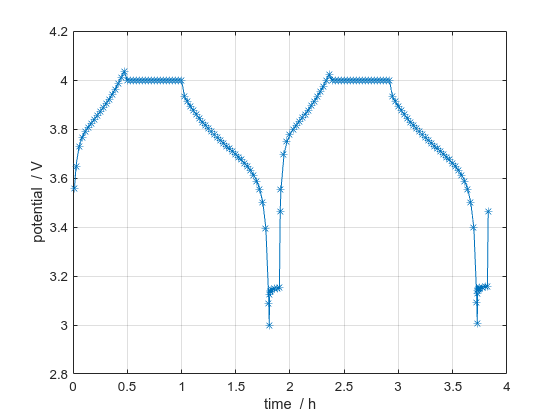

In [11]:
ind = cellfun(@(x) not(isempty(x)), states);
states = states(ind);
E = cellfun(@(x) x.Control.E, states);
I = cellfun(@(x) x.Control.I, states);
T = cellfun(@(x) max(x.(thermal).T), states);
Tmax = cellfun(@(x) max(x.ThermalModel.T), states);
% [SOCN, SOCP] =  cellfun(@(x) model.calculateSOC(x), states);
time = cellfun(@(x) x.time, states);

figure
plot(time/hour, E, '*-');
grid on
xlabel 'time  / h';
ylabel 'potential  / V';


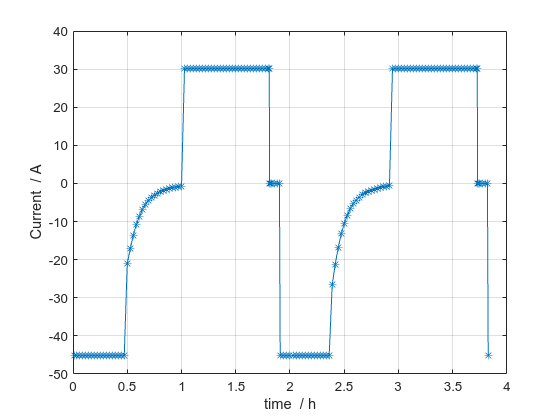

In [12]:

figure
plot(time/hour, I, '*-');
grid on
xlabel 'time  / h';
ylabel 'Current  / A';

In [13]:

writeh5 = false;
if writeh5
    writeOutput(model, states, 'output.h5');
end

%{
Copyright 2021-2024 SINTEF Industry, Sustainable Energy Technology
and SINTEF Digital, Mathematics & Cybernetics.

This file is part of The Battery Modeling Toolbox BattMo

BattMo is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

BattMo is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with BattMo.  If not, see <http://www.gnu.org/licenses/>.
%}